In [1]:
import uproot, pylhe, glob, os
import numpy as np
import numba,vector
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
lhe_signal=glob.glob("/localscratch/Samples/Signal/SM/WWW01j_000[0-4].lhe.gz")
root_signal=glob.glob("/localscratch/Samples/Signal/SM/WWW01j_000[0-4].root")

lhe_bkg=glob.glob("/localscratch/Samples/3l01j/3l01j_00[0-1]?.lhe.gz")
root_bkg=glob.glob("/localscratch/Samples/3l01j/3l01j_00[0-1]?.root")

In [3]:
def get_xSection(lhefiles):
    init=pylhe.read_lhe_init(lhefiles[0])

    xSection=0.
    for process in init['procInfo']:
        xSection+=process['xSection']
    return xSection # in pb

In [4]:
def getNeventsLHE(lhefiles):
    N=0
    for f in lhefiles:
        lines=os.popen('zgrep "</event>" '+f+"|wc -l").readlines()
        N+=int(lines[0])
    return N

In [5]:
xSection_sig=get_xSection(lhe_signal)
xSection_bkg=get_xSection(lhe_bkg)
print(xSection_sig,xSection_bkg)

0.017245120000000003 0.8901096


In [6]:
N_lhe_sig=getNeventsLHE(lhe_signal)
N_lhe_bkg=getNeventsLHE(lhe_bkg)
print(N_lhe_sig,N_lhe_bkg)

1000000 4000000


In [7]:
def getNeventsRoot(rootfiles):
    N=0
    for f in rootfiles:
        with uproot.open(f+':Delphes') as tree:
            N+=tree.num_entries
    return N

In [8]:
N_root_sig=getNeventsRoot(root_signal)
N_root_bgk=getNeventsRoot(root_bkg)
print(N_root_sig,N_root_bgk)

511723 2964674


In [9]:
#calculate resulting xSection*efficiency
xSection_sig*=N_root_sig/N_lhe_sig
xSection_bkg*=N_root_bgk/N_lhe_bkg
print(xSection_sig,xSection_bkg)

0.008824724541760002 0.6597211970676


In [10]:
#show available branches
tree=uproot.open(root_signal[0]+':Delphes')
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Event                | int32_t                  | AsDtype('>i4')
Event/Event.fUniq... | uint32_t[]               | AsJagged(AsDtype('>u4'))
Event/Event.fBits    | uint32_t[]               | AsJagged(AsDtype('>u4'))
Event/Event.Number   | int64_t[]                | AsJagged(AsDtype('>i8'))
Event/Event.ReadTime | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.ProcTime | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Proce... | int32_t[]                | AsJagged(AsDtype('>i4'))
Event/Event.MPI      | int32_t[]                | AsJagged(AsDtype('>i4'))
Event/Event.Weight   | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Cross... | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Cross... | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Scale    | 

In [11]:
#show only specifc elements
tree['MissingET'].show(filter_name="MissingET.*")

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
MissingET            | int32_t                  | AsDtype('>i4')                
MissingET.fUniqueID  | uint32_t[]               | AsJagged(AsDtype('>u4'))
MissingET.fBits      | uint32_t[]               | AsJagged(AsDtype('>u4'))
MissingET.MET        | float[]                  | AsJagged(AsDtype('>f4'))
MissingET.Eta        | float[]                  | AsJagged(AsDtype('>f4'))
MissingET.Phi        | float[]                  | AsJagged(AsDtype('>f4'))


In [12]:

tree['Electron'].show(filter_name="Electron.*", name_width=40)

name                                     | typename                 | interpretation                
-----------------------------------------+--------------------------+-------------------------------
Electron                                 | int32_t                  | AsDtype('>i4')                
Electron.fUniqueID                       | uint32_t[]               | AsJagged(AsDtype('>u4'))
Electron.fBits                           | uint32_t[]               | AsJagged(AsDtype('>u4'))
Electron.PT                              | float[]                  | AsJagged(AsDtype('>f4'))
Electron.Eta                             | float[]                  | AsJagged(AsDtype('>f4'))
Electron.Phi                             | float[]                  | AsJagged(AsDtype('>f4'))
Electron.T                               | float[]                  | AsJagged(AsDtype('>f4'))
Electron.Charge                          | int32_t[]                | AsJagged(AsDtype('>i4'))
Electron.EhadOverEem            

In [13]:
#specify the variables we are interested in
tree.keys(filter_name="/(MissingET.(MET|Phi)|Particle.(PID|Status)|Electron.(PT|Eta|Phi)|"
          "Muon.(PT|Eta|Phi)|Jet.(PT|Eta|Phi))/")

['Particle/Particle.PID',
 'Particle/Particle.Status',
 'Jet/Jet.PT',
 'Jet/Jet.Eta',
 'Jet/Jet.Phi',
 'Jet/Jet.PTD',
 'Electron/Electron.PT',
 'Electron/Electron.Eta',
 'Electron/Electron.Phi',
 'Muon/Muon.PT',
 'Muon/Muon.Eta',
 'Muon/Muon.Phi',
 'MissingET/MissingET.MET',
 'MissingET/MissingET.Phi']

In [14]:
@numba.jit(nopython=True)
def checkHiggs(batch):
    higgs=np.full((len(batch),),False)
    for i in range(len(batch)):
        for p in range(len(batch[i]['Particle.PID'])):
            if abs(batch[i]['Particle.PID'][p])==25:
                higgs[i]=True
                break
    return higgs

In [15]:
@numba.jit(nopython=True)
def get_MET(batch):
    met=np.zeros((len(batch),))
    for i in range(len(batch)):
        met[i]=float(batch[i]['MissingET.MET'][0])
    return met

In [16]:
@numba.jit(nopython=True)
def get_minDRll(batch):
    DRll=np.full((len(batch),),1000.)
    for i in range(len(batch)):
        leptons=[]

        #loop over electrons
        for e in range(len(batch[i]['Electron.PT'])):
            leptons.append(vector.obj(pt=batch[i]['Electron.PT'][e], 
                                      phi=batch[i]['Electron.Phi'][e], 
                                      eta=batch[i]['Electron.Eta'][e], 
                                      mass=511./1e6))
        #loop over muons
        for m in range(len(batch[i]['Muon.PT'])):
            leptons.append(vector.obj(pt=batch[i]['Muon.PT'][m], 
                                      phi=batch[i]['Muon.Phi'][m], 
                                      eta=batch[i]['Muon.Eta'][m], 
                                      mass=105.66/1e3))
        mindr=DRll[i]
        for l1 in leptons:
            for l2 in leptons:
                if l1==l2:
                    continue
                if l1.deltaR(l2)<mindr:
                    mindr=l1.deltaR(l2)

        DRll[i]=mindr
    return DRll

In [17]:
@numba.jit(nopython=True)
def preselection(batch):
    pass_selection=np.full((len(batch),),False)
    for i in range(len(batch)):
        nElectrons=0
        nMuons=0
        nJets=0

        for e in range(len(batch[i]['Electron.PT'])):
            if batch[i]['Electron.PT'][e]>=10.0 and abs(batch[i]['Electron.Eta'][e])<2.5:
                nElectrons+=1

        for m in range(len(batch[i]['Muon.PT'])):
            if batch[i]['Muon.PT'][m]>=10.0 and abs(batch[i]['Muon.Eta'][m])<2.5:
                nMuons+=1

        for j in range(len(batch[i]['Jet.PT'])):
            if batch[i]['Jet.PT'][j]>=25.0 and abs(batch[i]['Jet.Eta'][j])<2.5:
                nJets+=1

        if nElectrons+nMuons==3 and nJets<5:
            pass_selection[i]=True

    return pass_selection
    

In [18]:
met_VH=None
met_WWW=None
met_bkg=None

dr_VH=None
dr_WWW=None
dr_bkg=None

batch_size=5000

myfilter="/(MissingET.(MET|Phi)|Particle.(PID|Status)|Electron.(PT|Eta|Phi)|Muon.(PT|Eta|Phi)|Jet.(PT|Eta|Phi))/"

#loop over VH/WWW
ntotal_VH=0
nselected_VH=0
ntotal_WWW=0
nselected_WWW=0
iterator = uproot.iterate([f+":Delphes" for f in root_signal],step_size=batch_size, filter_name=myfilter)
for batch in tqdm(iterator, total=N_root_sig//batch_size):
        higgs=checkHiggs(batch)
        met=get_MET(batch)
        dr=get_minDRll(batch)
        presel=preselection(batch)
        if met_VH is not None:
                met_VH=np.concatenate((met_VH,met[np.logical_and(higgs,presel)]),axis=0)
                met_WWW=np.concatenate((met_WWW,met[np.logical_and(~higgs,presel)]),axis=0)

                dr_VH=np.concatenate((dr_VH,dr[np.logical_and(higgs,presel)]),axis=0)
                dr_WWW=np.concatenate((dr_WWW,dr[np.logical_and(~higgs,presel)]),axis=0)
        else:
                met_VH=np.array(met[np.logical_and(higgs,presel)])
                met_WWW=np.array(met[np.logical_and(~higgs,presel)])

                dr_VH=np.array(dr[np.logical_and(higgs,presel)])
                dr_WWW=np.array(dr[np.logical_and(~higgs,presel)])

        ntotal_VH+=higgs.sum()
        ntotal_WWW+=(~higgs).sum()
        nselected_VH+=np.logical_and(higgs,presel).sum()
        nselected_WWW+=np.logical_and(~higgs,presel).sum()

print("Preselection efficiency for VH events: %2.2f %%"%(100.*nselected_VH/ntotal_VH))
print("Preselection efficiency for WWW events: %2.2f %%"%(100.*nselected_WWW/ntotal_WWW))


#loop over background
ntotal=0
nselected=0
iterator = uproot.iterate([f+":Delphes" for f in root_bkg],step_size=batch_size, filter_name=myfilter)
for batch in tqdm(iterator, total=N_root_bgk/batch_size):
        met=get_MET(batch)
        dr=get_minDRll(batch)
        presel=preselection(batch)
        if met_bkg is not None:
                met_bkg=np.concatenate((met_bkg,met[presel]),axis=0)
                dr_bkg=np.concatenate((dr_bkg,dr[presel]),axis=0)
        else:
                met_bkg=np.array(met[presel])
                dr_bkg=np.array(dr[presel])

        ntotal+=len(batch)
        nselected+=presel.sum()
print("Preselection efficiency for background events: %2.2f %%"%(100.*nselected/ntotal))

105it [00:03, 26.62it/s]                                                                                                                                                                                                                                            


Preselection efficiency for VH events: 41.70 %
Preselection efficiency for WWW events: 43.09 %


 23%|████████████████████████████████████████████████▊                                                                                                                                                                       | 134/592.9348 [00:02<00:08, 53.11it/s]

In [ ]:
#scale to given luminosity
lumi=400 #inverse fb

n_sig=lumi*xSection_sig*1000
n_bkg=lumi*xSection_bkg*1000

weight_sig=n_sig/N_root_sig
weight_bkg=n_bkg/N_root_bgk

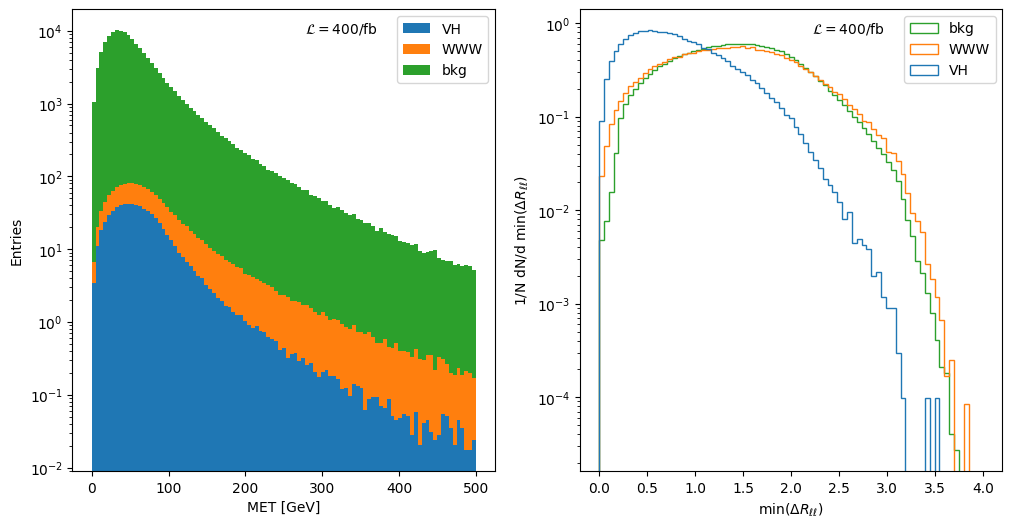

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
bins=np.linspace(0.,500.,100)
ax[0].hist([met_VH,met_WWW,met_bkg],bins=bins,
        weights=[np.full(met_VH.shape,weight_sig),
                 np.full(met_WWW.shape,weight_sig),
                 np.full(met_bkg.shape,weight_bkg)],
        histtype='bar', stacked=True,label=["VH","WWW","bkg"])
ax[0].set_yscale('log')
ax[0].text(0.55,0.95,"${\\cal L}=%3.0f$/fb"%lumi,transform=ax[0].transAxes)
ax[0].set_xlabel("MET [GeV]")
ax[0].set_ylabel("Entries")
ax[0].legend()

bins=np.linspace(0.,4.,80)
ax[1].hist([dr_VH,dr_WWW,dr_bkg],bins=bins,
        weights=[np.full(dr_VH.shape,weight_sig),
                 np.full(dr_WWW.shape,weight_sig),
                 np.full(dr_bkg.shape,weight_bkg)],
        histtype='step', stacked=False,density=True,label=["VH","WWW","bkg"])
ax[1].set_yscale('log')
ax[1].text(0.55,0.95,"${\\cal L}=%3.0f$/fb"%lumi,transform=ax[1].transAxes)
ax[1].set_xlabel("min($\\Delta R_{\\ell\\ell})$")
ax[1].set_ylabel("1/N dN/d min($\\Delta R_{\\ell\\ell})$")
ax[1].legend()